In [64]:
import tensorflow as tf 
import numpy as np
from scipy.ndimage import binary_dilation
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
!pip install neurokit2
import neurokit2 as nk
import wfdb 



Defaulting to user installation because normal site-packages is not writeable


In [297]:

# Define the custom focal loss function
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        CE = -tf.keras.backend.log(pt)
        FL = tf.keras.backend.pow(1 - pt, gamma) * CE
        return tf.keras.backend.mean(alpha * FL)
    return focal_loss_fixed

# Load the model with the custom loss function
model = keras.models.load_model("training.keras", custom_objects={'focal_loss_fixed': focal_loss(gamma=2., alpha=0.25)})

#### Testing model's prediction on afib signals from datasets online 

In [277]:
def preprocess_data(ecg_signal):
    """Preprocess data to match training format."""
    # Normalize the signal to match training preprocessing
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_signal = scaler.fit_transform(ecg_signal.reshape(-1, 1)).reshape(1, -1)
    if scaled_signal.shape[1] != 2500:
        raise ValueError(f"Expected signal length 2500, got {scaled_signal.shape[1]}")
    return scaled_signal.reshape(1, 2500, 1)  


In [278]:

def load_ecg_signal(file_path, start, end):
    """Load ECG signal from a file."""
    s, _ = wfdb.io.rdsamp(file_path)
    return s[:, 0][start:end]

def detect_rpeaks_nk2(ecg_signal, sampling_rate=200):
    """Detect R-peaks using neurokit2."""
    _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sampling_rate)
    return rpeaks['ECG_R_Peaks']

def preprocess_and_predict(ecg_signal, model, threshold=0.7):
    """Preprocess ECG signal and make predictions."""
    preprocessed_signal = preprocess_data(ecg_signal)
    predictions = model.predict(preprocessed_signal)
    return (predictions > threshold).astype(int).flatten()

def find_true_r_peaks(predictions, window_size=5):
    """Find true R-peaks with window condition."""
    true_peaks = np.zeros_like(predictions)
    for i in range(len(predictions) - window_size + 1):
        window = predictions[i:i+window_size]
        if all(window == 1):
            peak_index = i + window_size//2
            if true_peaks[peak_index] == 0:  # Avoid overlapping peaks
                true_peaks[peak_index] = 1
                true_peaks[max(0, peak_index-window_size):peak_index] = 0
                true_peaks[peak_index+1:min(len(true_peaks), peak_index+window_size+1)] = 0
    return true_peaks

In [279]:
def plot_ecg_with_peaks(ecg_signal, time_axis, true_peaks, nk2_peaks):
    """Plot ECG signal with detected peaks."""
    plt.figure(figsize=(12, 8))

    # Plot 1: ECG Signal with true R-peaks from the model
    plt.subplot(2, 1, 2)
    plt.plot(time_axis, ecg_signal, label='ECG Signal', alpha=0.5)
    plt.plot(time_axis, true_peaks * np.max(ecg_signal), 'g', label='True R-peaks')
    plt.plot(time_axis[nk2_peaks], ecg_signal[nk2_peaks], 'ro', label='NK2 R-peaks')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('ECG Signal with True R-Peaks (Window Method)')
    plt.legend()

    # Plot 2: ECG Signal with neurokit2 R-peaks
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, ecg_signal, label='ECG Signal')
    plt.plot(time_axis[nk2_peaks], ecg_signal[nk2_peaks], 'ro', label='NK2 R-peaks')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title('ECG Signal with Neurokit2 R-Peaks')
    plt.legend()

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


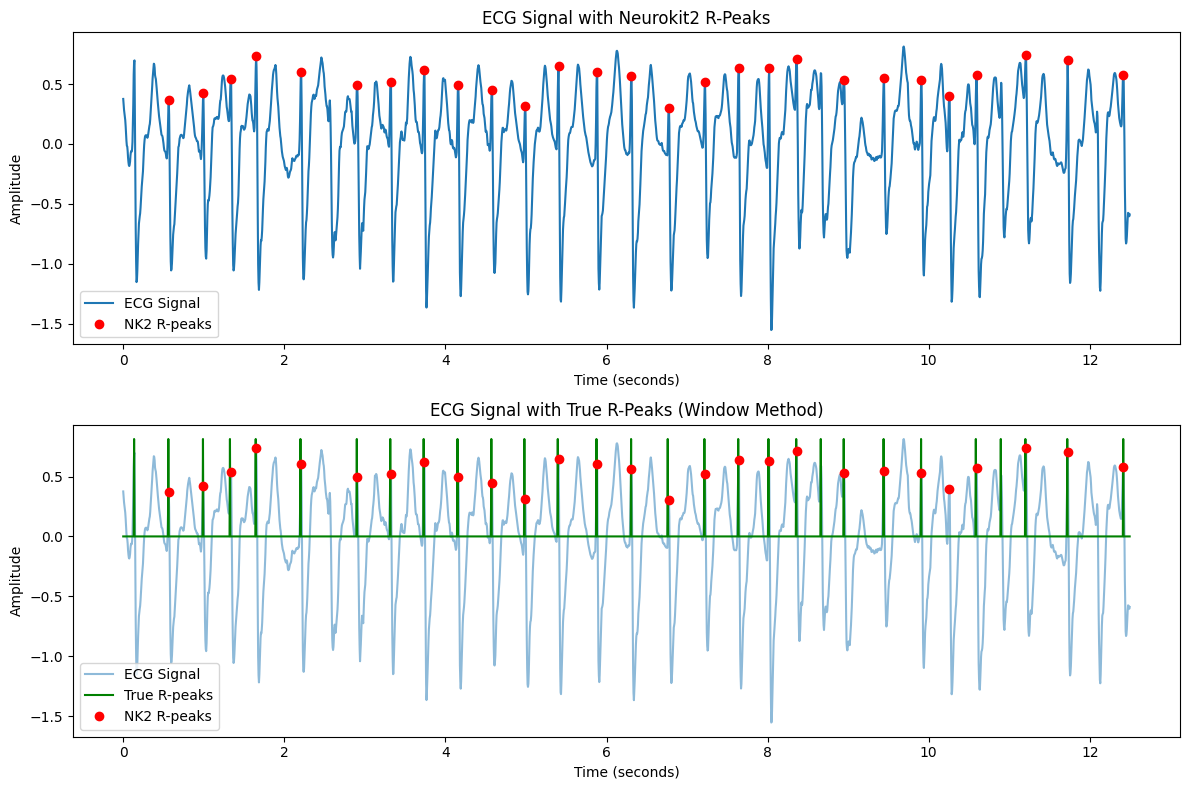

In [311]:
# Load the ECG signal
ecg_signal = load_ecg_signal("test_data/japan/009",start=15224500,end=15227000)

# Detect R-peaks using neurokit2
r_nk = detect_rpeaks_nk2(ecg_signal)

# Preprocess and predict
y_pred_processed = preprocess_and_predict(ecg_signal, model,threshold=0.7)

# Find true R-peaks with window condition
true_peaks = find_true_r_peaks(y_pred_processed,window_size=4)


# Create time axis
time_axis = np.arange(len(ecg_signal)) / 200

# Plot results
plot_ecg_with_peaks(ecg_signal, time_axis, true_peaks, r_nk)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


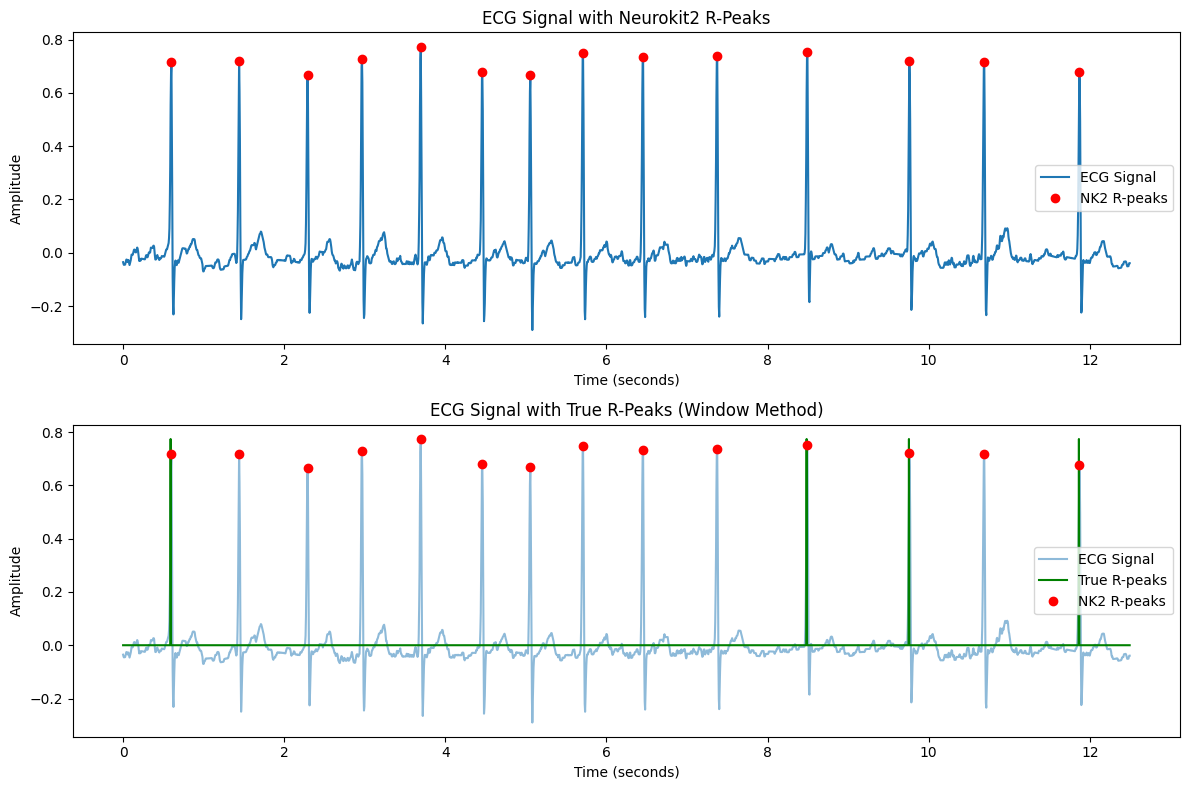

In [308]:
# Load the ECG signal
ecg_signal = load_ecg_signal("test_data/japan/003",start=17178400,end=17180900)

# Detect R-peaks using neurokit2
r_nk = detect_rpeaks_nk2(ecg_signal)

# Preprocess and predict 
y_pred_processed = preprocess_and_predict(ecg_signal, model,threshold=0.5)

# Find true R-peaks with window condition
true_peaks = find_true_r_peaks(y_pred_processed,window_size=5)

# Create time axis
time_axis = np.arange(len(ecg_signal)) / 200

# Plot results
plot_ecg_with_peaks(ecg_signal, time_axis, true_peaks, r_nk)